Open Data Project Presentation CODE1161 
Name: Zhang Wang  (z5248079)

Topic: Crash Data in Queensland, Australia

Introduction
"Damage Cost Analysis" is a method of conducting economic analysis on the damages caused by accidents, disasters, or other events. This analysis aims to estimate the losses incurred by the event, including direct economic losses, indirect economic impacts, and other related costs. The purpose of this analysis is to help decision-makers understand the potential consequences of the event, providing a basis for policy-making, taking actions, or making investment decisions.


In [1]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
from scipy.stats import chi2_contingency
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.colors import ListedColormap
file_name = "/workspaces/dateproject/crashdate.csv"

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (50, 20)

In [13]:
penalty_data = pd.read_csv('/workspaces/dateproject/crashdate.csv')


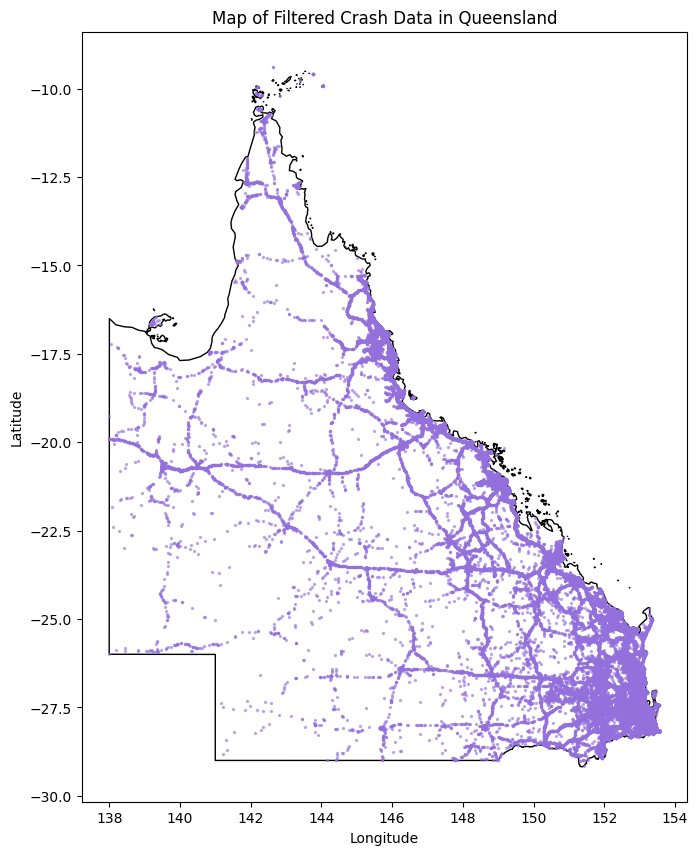

In [4]:
# Define valid ranges for longitude and latitude
valid_longitude_range = (130, 160)
valid_latitude_range = (-30, 0)

# Filter the penalty_data based on valid longitude and latitude ranges
filtered_data = penalty_data[
    (penalty_data['Crash_Longitude'] >= valid_longitude_range[0]) &
    (penalty_data['Crash_Longitude'] <= valid_longitude_range[1]) &
    (penalty_data['Crash_Latitude'] >= valid_latitude_range[0]) &
    (penalty_data['Crash_Latitude'] <= valid_latitude_range[1])
]

# Read the Queensland geospatial data
queensland = gp.read_file(
    '/workspaces/dateproject/date/queensland.json'
)

# Create a GeoDataFrame with filtered data points
filtered_points = gp.GeoDataFrame(geometry=gp.points_from_xy(
    filtered_data['Crash_Longitude'], filtered_data['Crash_Latitude']
))

# Create a plot showing the Queensland boundary and the filtered data points
fig, axs = plt.subplots(figsize=(20, 10))
queensland.boundary.plot(ax=axs, color='black', linewidth=1)  # Plot Queensland boundary
filtered_points.plot(ax=axs, marker='o', markersize=2,
                     alpha=0.5, color='mediumpurple', zorder=2)  # Plot filtered data points
axs.set_title('Map of Filtered Crash Data in Queensland')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

# Display the plot
plt.show()


In [5]:
# Load the geospatial data for localities from the specified shapefile
burbs = gp.GeoDataFrame.from_file(
    '/workspaces/dateproject/date/GDA2020/qld_localities.shp'
)
# Set the Coordinate Reference System (CRS) for the geospatial data
# This ensures that the spatial information is interpreted correctly
# The specified EPSG code (5234) represents GDA2020
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)
# Define a function that calculates the centroid of a geometry
def add_centroid(row):
    return row.geometry.centroid

# Apply the "add_centroid" function to each row in the GeoDataFrame "burbs"
# along the specified axis (axis=1 indicates applying the function to rows)
# The result is stored in a new column called "centroid"
burbs["centroid"] = burbs.apply(add_centroid, axis=1)

# Sample two random rows from the GeoDataFrame "burbs"
# This provides a glimpse of the data after adding the "centroid" column
burbs.sample(2)
# Extract the geometry (locality polygon) of the second row from the GeoDataFrame "burbs"
a = burbs.iloc[1]

# Calculate and print the centroid of the extracted geometry (locality polygon)
print(a.centroid)

POINT (152.01080397169943 -24.830328047524123)


In [6]:
# Create a Shapely Point object representing the coordinates of a location
right_here = shapely.geometry.point.Point(153.0587653330788, -27.478362304023605)

# Calculate the distance from each locality centroid to the specified location (right_here)
# The calculated distances are stored in a new column named "distance_from_UNSW"
burbs["distance_from_The_selected_center_point"] = burbs.centroid.distance(right_here)
# Select localities from the GeoDataFrame "burbs" that are within a certain distance (less than 0.03) from UNSW
close_burbs = burbs[burbs.distance_from_The_selected_center_point < 0.022]
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
for point in points:
    pass
# Create a list of points from the latitude and longitude columns in the penalty_data DataFrame
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))

# Iterate over each point in the list (currently just a placeholder pass)
for point in points:
    pass

# Create another list of points from the latitude and longitude columns in the penalty_data DataFrame
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))

# Iterate over each point in the list (currently just a placeholder pass)
for point in points:
    pass

# Specify the column containing geometry information in the close_burbs GeoDataFrame
polygon_column = 'geometry'

# Extract the polygons from the specified geometry column
polygons = close_burbs[polygon_column]

# Convert the list of polygon coordinates to a list of Polygon objects
polygonslist = [Polygon(coords) for coords in polygons]

# Create a MultiPolygon object from the list of Polygon objects
multi_polygon = MultiPolygon(polygonslist)

# Find the points that are inside the MultiPolygon
points_inside_polygons = [
    point for point in points if multi_polygon.contains(Point(point))
]

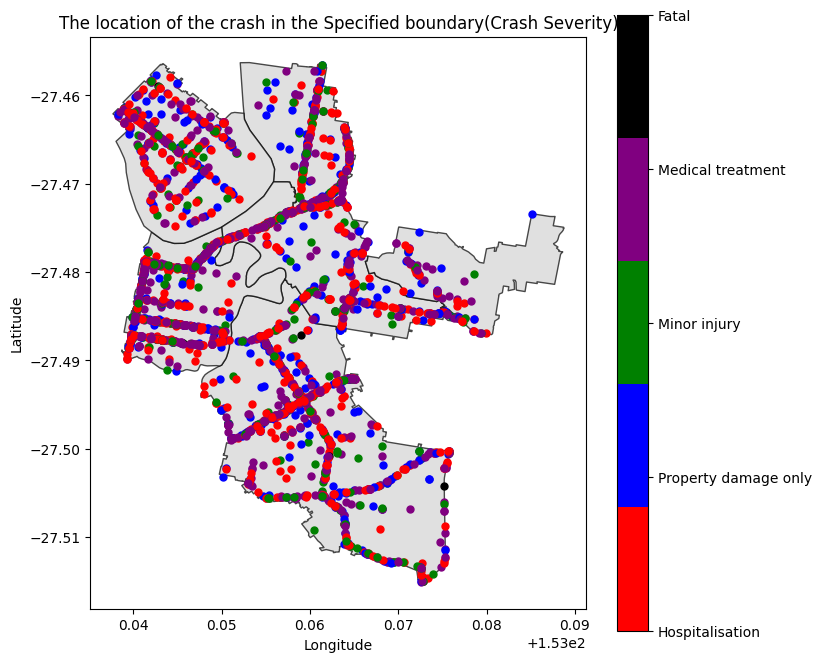

In [7]:
# Extract the 'Crash_Severity' column as labels for crash severity levels
crash_severity_labels = penalty_data['Crash_Severity']

# Define the labels for crash severity levels
severity_labels = ['Hospitalisation', 'Property damage only', 'Minor injury', 'Medical treatment', 'Fatal']

# Create a mapping from crash severity labels to numeric values
severity_mapping = {label: index for index, label in enumerate(severity_labels)}

# Map crash severity labels to numeric values using the defined mapping
crash_severity_numeric = [severity_mapping[label] for label in crash_severity_labels]

# Define colors for each crash severity level
colors = ['red', 'blue', 'green', 'purple', 'black']

# Create a colormap for the crash severity levels
cmap = ListedColormap(colors)

# Define a color normalization range
norm = plt.Normalize(vmin=0, vmax=len(severity_labels) - 1)

# Create a ScalarMappable for the colormap and set it to the current color array
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Specify the column containing geometry information in the close_burbs GeoDataFrame
polygon_column = 'geometry'

# Extract the polygons from the specified geometry column
polygons = close_burbs[polygon_column]

# Convert the list of polygon coordinates to a list of Polygon objects
polygonslist = [Polygon(coords) for coords in polygons]

# Create a MultiPolygon object from the list of Polygon objects
multi_polygon = MultiPolygon(polygonslist)

# Find the points and their corresponding crash severity levels that are inside the MultiPolygon
points_inside_polygons = [
    (point, severity) for point, severity in zip(points, crash_severity_numeric) if multi_polygon.contains(Point(point))
]

# Create a plot to visualize the points inside the polygons with colors representing crash severity levels
fig, ax = plt.subplots(figsize=(8,8))

# Plot the close_burbs GeoDataFrame as a background
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)

# Plot the points inside the polygons using different colors based on crash severity levels
for point, severity in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(severity), markersize=5)

# Create a colorbar to show the mapping between colors and crash severity levels
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(severity_labels)))
cbar.set_ticklabels(severity_labels)

# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary(Crash Severity)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()


In [8]:
# Define the file path to the CSV file containing the data
file_path = '/workspaces/dateproject/crashdate.csv'

# Read the data from the CSV file into a DataFrame
data = pd.read_csv(file_path)


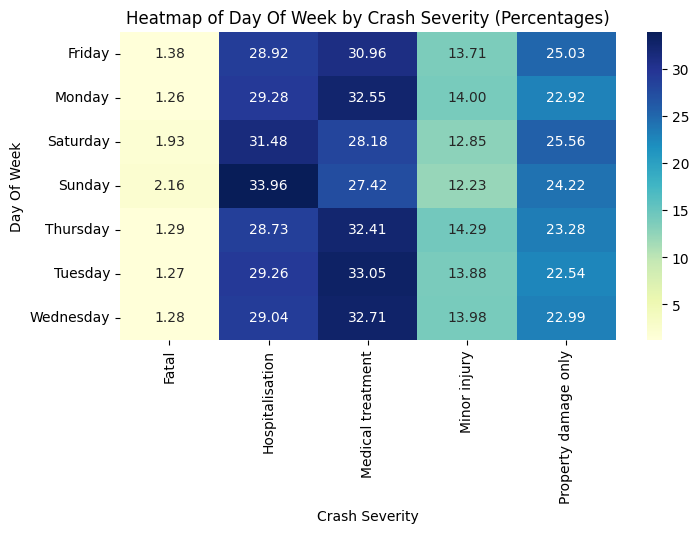

In [9]:
# Create a cross-tabulation between 'Crash_Day_Of_Week' and 'Crash_Severity'
cross_tab = pd.crosstab(data["Crash_Day_Of_Week"], data["Crash_Severity"])


# Normalize the crosstab by row (Crash_Day_Of_Week) to get percentages
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Create a heatmap of the normalized crosstab (percentages)
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab_percent, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Heatmap of Day Of Week by Crash Severity (Percentages)")
plt.xlabel("Crash Severity")
plt.ylabel("Day Of Week")
plt.show()

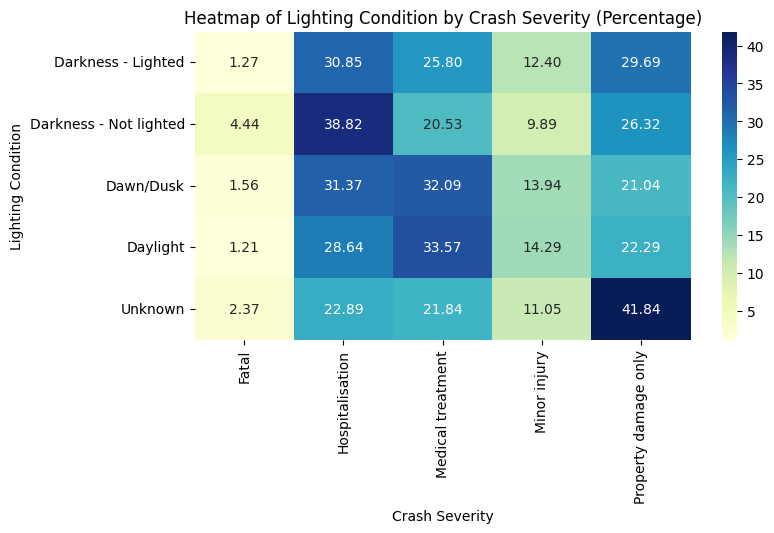

In [10]:
from sklearn.preprocessing import LabelEncoder
# Define a custom order for the speed limit categories
speed_limit_order = ["0 - 50 km/h", "60 km/h", "70 km/h", "80 - 90 km/h", "100 - 110 km/h"]


# Create another cross-tabulation between 'Crash_Lighting_Condition' and 'Crash_Severity'
cross_tab = pd.crosstab(data["Crash_Lighting_Condition"], data["Crash_Severity"])

# Calculate percentages within each row (lighting condition category) to create a percentage heatmap
cross_tab_percentage = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Create a heatmap to visualize the percentage cross-tabulation
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab_percentage, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Heatmap of Lighting Condition by Crash Severity (Percentage)")
plt.xlabel("Crash Severity")
plt.ylabel("Lighting Condition")
plt.show()

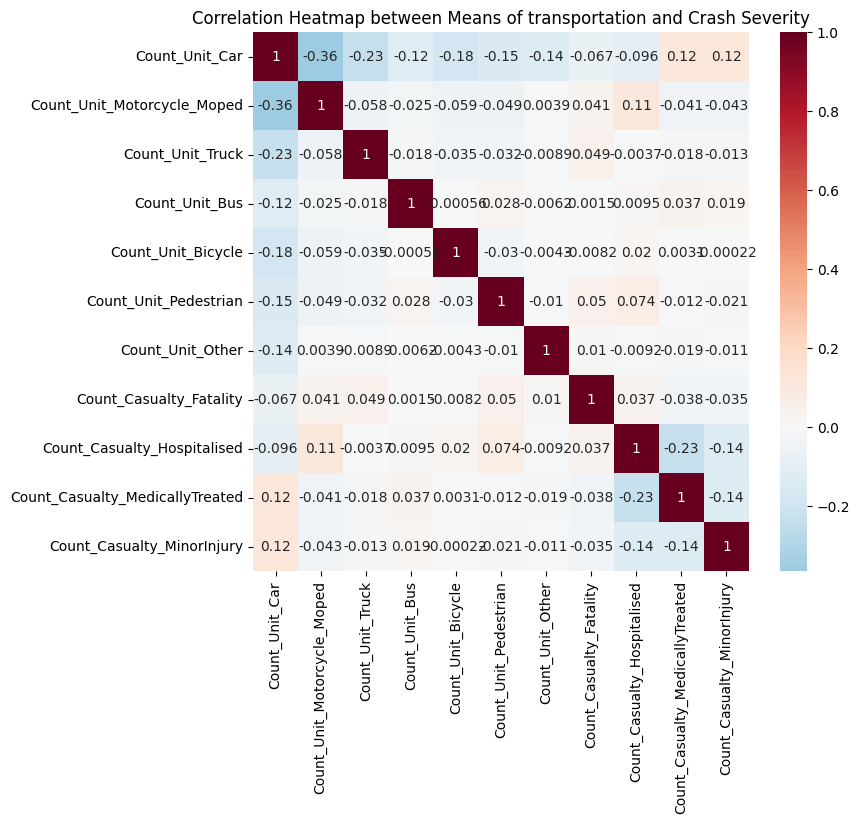

In [11]:
# Define a list of columns of interest related to traffic units and casualty counts
columns_of_interest = [
    "Count_Unit_Car", "Count_Unit_Motorcycle_Moped", "Count_Unit_Truck",
    "Count_Unit_Bus", "Count_Unit_Bicycle", "Count_Unit_Pedestrian",
    "Count_Unit_Other",
    "Count_Casualty_Fatality", "Count_Casualty_Hospitalised",
    "Count_Casualty_MedicallyTreated", "Count_Casualty_MinorInjury"
]

# Subset the data to include only the columns of interest
subset_data = data[columns_of_interest]

# Calculate the correlation matrix between the selected columns
correlation_matrix = subset_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8,7))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r", center=0)

# Set the title for the heatmap
plt.title("Correlation Heatmap between Means of transportation and Crash Severity")

# Display the heatmap
plt.show()